In [208]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import warnings
warnings.simplefilter('ignore')

In [129]:
key_path = "C:/Users/Андрей/computer/Desktop/YouControl_test/youcontrol-test-project-de9175ee8095.json"

# Створення клієнта BigQuery
client = bigquery.Client.from_service_account_json(key_path)

query = """
    select* from `youcontrol-test-project.youcontrol_test_dataset.Test`
"""

# Загрузка результату запита в Pandas DataFrame
df = client.query(query).to_dataframe()

C:\ESD\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
C:\ESD\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
C:\ESD\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
C:\ESD\lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [130]:
df

,userID,Product_type,Date,views
0,foUKgB8/h8moVnsU1vA7UQ==,8,2023-12-17,1
1,nFyq85sUULPUXpCfHgNMDQ==,8,2023-12-17,1
2,d6+xETK8BFURfk+Wzx7bng==,8,2023-12-17,1
3,5792oqZmf9hMo+scsWo+IQ==,8,2023-12-17,1
4,5Tk7qXvvF8Kglhcs/gyzEA==,8,2023-12-17,1
...,...,...,...,...
275090,4pw/Y24NW8g3yI4eU6ce+Q==,8,2023-10-09,202
275091,q1c/c2Nu/TO6ay7k1cZorw==,8,2023-03-20,207
275092,WvuxNjeJoXxNua8m0mVoWQ==,8,2023-01-29,213
275093,hgzEu4H/hu1GU2K/QnCc7Q==,8,2023-11-24,492


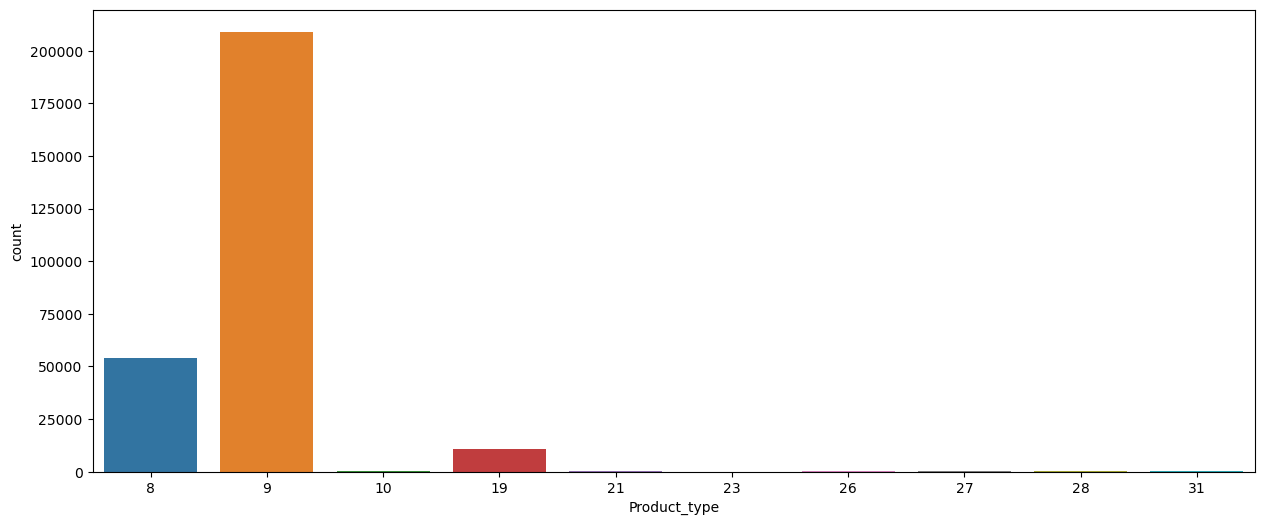

In [207]:
#Найбільша кількість запитів в наборі данних до продуктів з ID 8, 9, 19
plt.figure(figsize=(15, 6))
sns.countplot(df.Product_type);

In [192]:
df.Product_type.value_counts()

9     209122
8      54119
19     10955
27       291
26       184
28       144
10       138
31        62
21        42
23        38
Name: Product_type, dtype: Int64

In [193]:
number_of_unique_users_by_product = df.groupby(['Product_type']) \
    .agg({'userID': pd.Series.nunique}) \
    .reset_index() \
    .rename(columns={'userID':'number_of_unique_users'})

In [194]:
number_of_unique_users_by_product

,Product_type,number_of_unique_users
0,8,2353
1,9,859
2,10,20
3,19,226
4,21,23
5,23,23
6,26,52
7,27,34
8,28,24
9,31,30


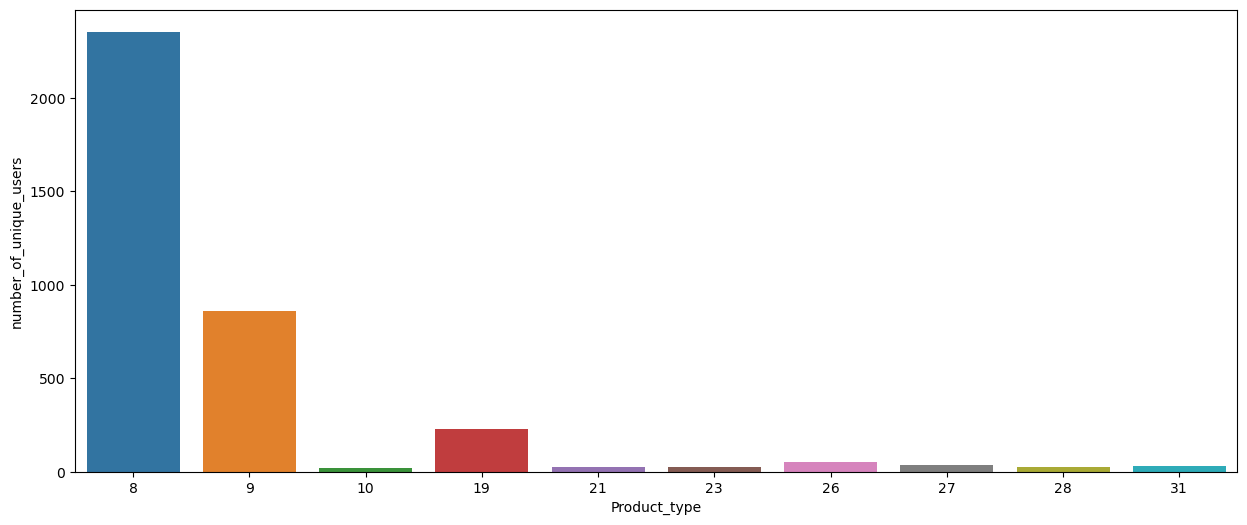

In [211]:
#Найбільша кістькість унікальних користувачів у продуктів з ID 8, 9, 19
#Відповідно до цього можна прийняти рішення, щодо покращення сильних продуктів, та розподілу ресурсів на їх користь.
plt.figure(figsize=(15, 6))
sns.barplot(number_of_unique_users_by_product.Product_type, number_of_unique_users_by_product.number_of_unique_users);

In [212]:
df_aggregated = df.groupby(['Date','Product_type']).agg({'views':'sum'}).reset_index()

In [213]:
df_aggregated

,Date,Product_type,views
0,2023-01-01,8,255
1,2023-01-01,9,796
2,2023-01-01,19,105
3,2023-01-02,8,777
4,2023-01-02,9,796
...,...,...,...
1647,2023-12-22,19,2
1648,2023-12-22,27,1
1649,2023-12-24,9,847
1650,2023-12-24,27,1


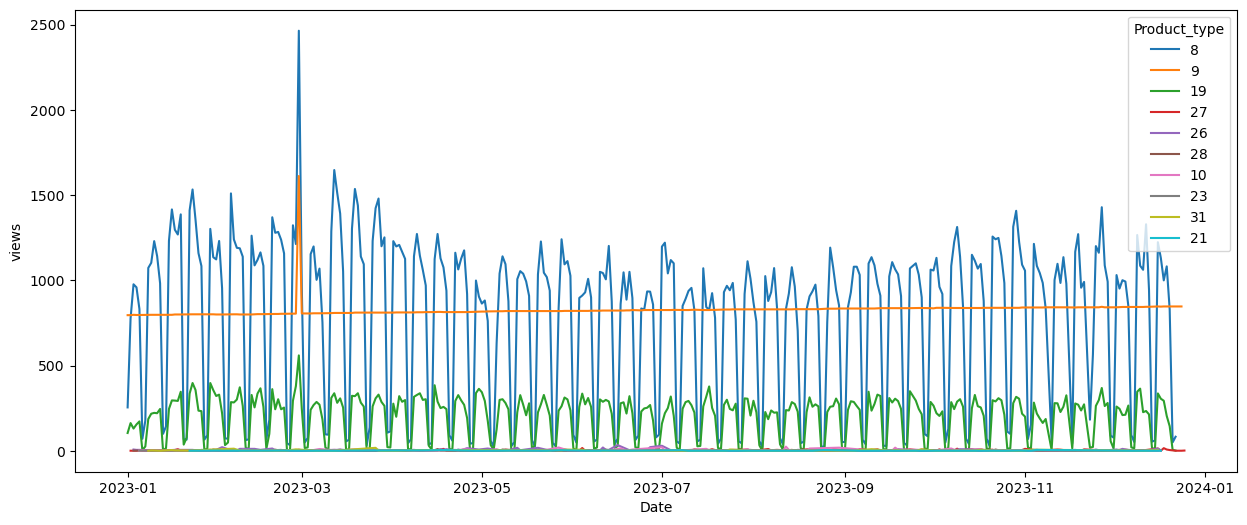

In [215]:
#Графік в динаміці просумованої кількості переглядів для кожного з продуктів
#1. Можемо побачити доволі велику змінність(дисперсію) кількості переглядів, це відбувається за рахунок того,
# що нашими продуктами на вихідних майже не користуються(виключенням є продукт з ID 9 у якого кількість переглядів майже завжди близько 800)
#2. Виходячи з першго твердження вихідні дні є найкращими для впровадження оновлень та проведення тестувань нових функцій в продуктах
plt.figure(figsize=(15, 6))
df_aggregated['Product_type'] = df_aggregated['Product_type'].astype(str)  
sns.lineplot(df_aggregated.Date, df_aggregated.views, hue=df_aggregated.Product_type);

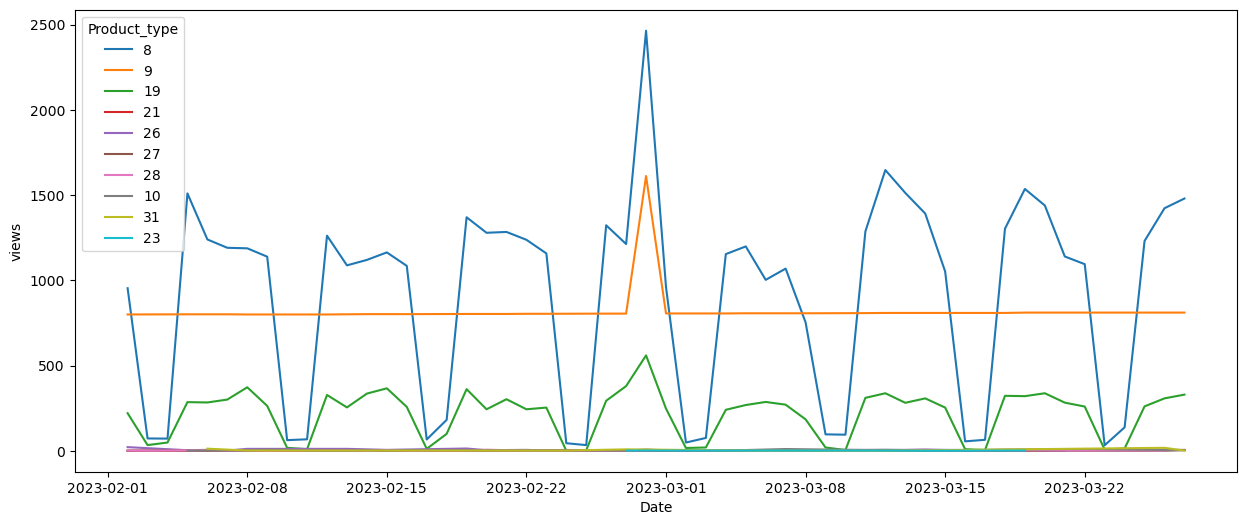

In [216]:
#Демонстрація тижневої сезонності в кількості переглядів по продуктам
data = df_aggregated[
    (df_aggregated['Date'] > datetime.strptime('2023-02-01', '%Y-%m-%d')) & 
    (df_aggregated['Date'] < datetime.strptime('2023-03-28', '%Y-%m-%d'))]

plt.figure(figsize=(15, 6))
data['Product_type'] = data['Product_type'].astype(str)  
sns.lineplot(data.Date, data.views, hue=data.Product_type);

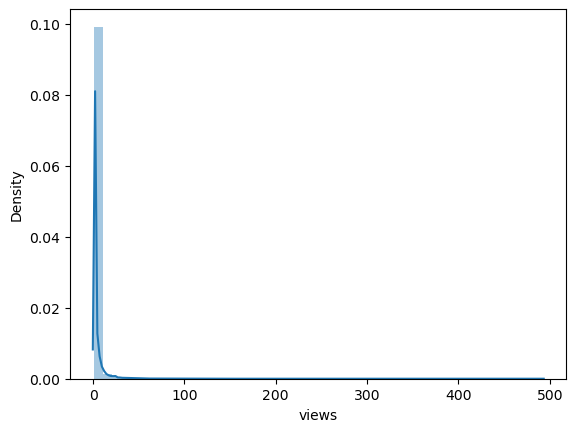

In [218]:
#Розподіл переглядів, можемо побачити перекіс в ліву сторону та хвіст в праву, 
#яким каже нам про наявні викиди з велики значеннями порівняно з середнім та медіанним значеннями.
sns.distplot(df.views);

In [221]:
df.views.median()

1.0

In [220]:
df.views.mean()

2.032414256893073

In [200]:
df.views.value_counts()

1      234052
2       12551
3        6801
4        4353
5        3121
        ...  
213         1
492         1
155         1
127         1
251         1
Name: views, Length: 155, dtype: Int64